In [1]:
!pip3 install -r requirements.txt

In [2]:
# run once
import musdb

mus = musdb.DB(download=True)

Done!


In [3]:
import os
import musdb

musdb_location = 'musdb18'
os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path
mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import museval
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import os
import musdb
import torch
import transforms
import utils
from mdensenet import MDenseNetBackbone, MDenseNet, DenseBlock

import tqdm

In [8]:
print('sampling tracks')
rng = np.random.default_rng()
train_size, valid_size = 80, 14
sample_length_seconds = 5
mixtures_train, targets_train = utils.sample_musdb_tracks(mus_train.tracks[:train_size], sample_length_seconds, sample_targets='vocals', rng=rng)
mixtures_valid, targets_valid = utils.sample_musdb_tracks(mus_valid.tracks[:valid_size], sample_length_seconds, sample_targets='vocals', rng=rng)
print('calculating stft')
mixtures_stft, targets_stft = transforms.stft(torch.tensor(mixtures_train), to_complex=False), transforms.stft(torch.tensor(targets_train), to_complex=False)
mixtures_stft_valid, targets_stft_valid = transforms.stft(torch.tensor(mixtures_valid), to_complex=False), transforms.stft(torch.tensor(targets_valid), to_complex=False)


sampling tracks
calculating stft


In [32]:
mixtures_stft, targets_stft = mixtures_stft.cuda(), targets_stft.cuda()
mixtures_stft_valid, targets_stft_valid = mixtures_stft_valid.cuda(), targets_stft_valid.cuda()

In [11]:
class STFTDataset(torch.utils.data.Dataset):
    def __init__(self, mixture_stft, target_stft):
        self.mixture_stft = mixture_stft
        self.target_stft = target_stft

    def __len__(self):
        return len(self.mixture_stft)

    def __getitem__(self, idx):
        return self.mixture_stft[idx], self.target_stft[idx]

In [107]:
batch_size = 8
valid_batch_size = 16

training_data = STFTDataset(mixtures_stft, targets_stft)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = STFTDataset(mixtures_stft_valid, targets_stft_valid)
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [106]:
in_channels, num_features = 2, 32

growth_rate = [12,12,12,12,12,12,12]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
depth = [4,4,4,4,4,4,4]

growth_rate_final=4
kernel_size_final=3
depth_final=2
# max_bin = mixtures_stft.size()[2]
max_bin=2049
dilated_final=True
norm_final=True
nonlinear_final=True

model = MDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final,
    max_bin=max_bin)
model = model.type(torch.double)
model.cuda()
loss_fn = nn.MSELoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.num_parameters

120050

In [108]:
epochs = 100
train_losses, valid_losses = [], []

for epoch in tqdm.tqdm(range(epochs)):

    model.train()
    train_loss = 0.
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(mixture)

        loss = loss_fn(outputs, target)
        loss.backward()
        optimizer.step()
        
        # print(f'batch {i} loss {loss.item()}')
        train_loss += loss.item()


    model.eval()
    valid_loss = 0.
    with torch.no_grad():
      for i, (mixture, target) in enumerate(valid_loader):
        outputs = model(mixture)
        loss = loss_fn(outputs, target)
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f' epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')

model_path = f'trained_model_epoch_{epochs}.pt'
torch.save(model.cpu().state_dict(), model_path)
print(f'Done, model saved at {model_path}')

  1%|          | 1/100 [00:32<53:51, 32.64s/it]

 epoch 0: train loss 4.840532 valid loss 5.236106


  2%|▏         | 2/100 [01:05<53:06, 32.52s/it]

 epoch 1: train loss 4.265275 valid loss 4.811209


  3%|▎         | 3/100 [01:37<52:30, 32.48s/it]

 epoch 2: train loss 4.025480 valid loss 4.448875


  4%|▍         | 4/100 [02:09<51:56, 32.46s/it]

 epoch 3: train loss 3.883484 valid loss 4.298729


  5%|▌         | 5/100 [02:42<51:23, 32.45s/it]

 epoch 4: train loss 3.789449 valid loss 4.211486


  6%|▌         | 6/100 [03:14<50:49, 32.44s/it]

 epoch 5: train loss 3.714625 valid loss 4.258228


  7%|▋         | 7/100 [03:47<50:16, 32.44s/it]

 epoch 6: train loss 3.649751 valid loss 4.197588


  8%|▊         | 8/100 [04:19<49:44, 32.44s/it]

 epoch 7: train loss 3.586040 valid loss 4.364068


  9%|▉         | 9/100 [04:52<49:11, 32.44s/it]

 epoch 8: train loss 3.541404 valid loss 4.169985


 10%|█         | 10/100 [05:24<48:39, 32.44s/it]

 epoch 9: train loss 3.491507 valid loss 4.327786


 11%|█         | 11/100 [05:56<48:06, 32.44s/it]

 epoch 10: train loss 3.471043 valid loss 4.024527


 12%|█▏        | 12/100 [06:29<47:34, 32.44s/it]

 epoch 11: train loss 3.421413 valid loss 4.031096


 13%|█▎        | 13/100 [07:01<47:02, 32.45s/it]

 epoch 12: train loss 3.410850 valid loss 4.042639


 14%|█▍        | 14/100 [07:34<46:29, 32.44s/it]

 epoch 13: train loss 3.377584 valid loss 4.136514


 15%|█▌        | 15/100 [08:06<45:57, 32.44s/it]

 epoch 14: train loss 3.379831 valid loss 4.078746


 16%|█▌        | 16/100 [08:39<45:24, 32.43s/it]

 epoch 15: train loss 3.348153 valid loss 4.010598


 17%|█▋        | 17/100 [09:11<44:52, 32.44s/it]

 epoch 16: train loss 3.313589 valid loss 4.205917


 18%|█▊        | 18/100 [09:44<44:19, 32.44s/it]

 epoch 17: train loss 3.301721 valid loss 4.073211


 19%|█▉        | 19/100 [10:16<43:46, 32.43s/it]

 epoch 18: train loss 3.293744 valid loss 4.059707


 20%|██        | 20/100 [10:48<43:14, 32.43s/it]

 epoch 19: train loss 3.297482 valid loss 4.019301


 21%|██        | 21/100 [11:21<42:42, 32.43s/it]

 epoch 20: train loss 3.252995 valid loss 4.324088


 22%|██▏       | 22/100 [11:53<42:10, 32.44s/it]

 epoch 21: train loss 3.271727 valid loss 4.042321


 23%|██▎       | 23/100 [12:26<41:37, 32.44s/it]

 epoch 22: train loss 3.233625 valid loss 4.080080


 24%|██▍       | 24/100 [12:58<41:05, 32.44s/it]

 epoch 23: train loss 3.229668 valid loss 4.017424


 25%|██▌       | 25/100 [13:31<40:33, 32.44s/it]

 epoch 24: train loss 3.211410 valid loss 4.010328


 26%|██▌       | 26/100 [14:03<40:00, 32.44s/it]

 epoch 25: train loss 3.227295 valid loss 4.135745


 27%|██▋       | 27/100 [14:35<39:28, 32.44s/it]

 epoch 26: train loss 3.202050 valid loss 3.995829


 28%|██▊       | 28/100 [15:08<38:55, 32.44s/it]

 epoch 27: train loss 3.189513 valid loss 4.093128


 29%|██▉       | 29/100 [15:40<38:23, 32.44s/it]

 epoch 28: train loss 3.190683 valid loss 3.988871


 30%|███       | 30/100 [16:13<37:50, 32.44s/it]

 epoch 29: train loss 3.186055 valid loss 4.047957


 31%|███       | 31/100 [16:45<37:18, 32.44s/it]

 epoch 30: train loss 3.208764 valid loss 4.045738


 32%|███▏      | 32/100 [17:18<36:45, 32.43s/it]

 epoch 31: train loss 3.184057 valid loss 4.068508


 33%|███▎      | 33/100 [17:50<36:13, 32.44s/it]

 epoch 32: train loss 3.163912 valid loss 3.987014


 34%|███▍      | 34/100 [18:23<35:41, 32.44s/it]

 epoch 33: train loss 3.141328 valid loss 3.999990


 35%|███▌      | 35/100 [18:55<35:08, 32.45s/it]

 epoch 34: train loss 3.155231 valid loss 4.085950


 36%|███▌      | 36/100 [19:27<34:36, 32.44s/it]

 epoch 35: train loss 3.149571 valid loss 3.999037


 37%|███▋      | 37/100 [20:00<34:04, 32.45s/it]

 epoch 36: train loss 3.166450 valid loss 4.003998


 38%|███▊      | 38/100 [20:32<33:31, 32.45s/it]

 epoch 37: train loss 3.155926 valid loss 4.069251


 39%|███▉      | 39/100 [21:05<32:58, 32.44s/it]

 epoch 38: train loss 3.148967 valid loss 4.157160


 40%|████      | 40/100 [21:37<32:26, 32.43s/it]

 epoch 39: train loss 3.153975 valid loss 4.065679


 41%|████      | 41/100 [22:10<31:53, 32.44s/it]

 epoch 40: train loss 3.129789 valid loss 4.197264


 42%|████▏     | 42/100 [22:42<31:21, 32.44s/it]

 epoch 41: train loss 3.148821 valid loss 4.072436


 43%|████▎     | 43/100 [23:14<30:48, 32.43s/it]

 epoch 42: train loss 3.115389 valid loss 4.055465


 44%|████▍     | 44/100 [23:47<30:16, 32.43s/it]

 epoch 43: train loss 3.112978 valid loss 4.116552


 45%|████▌     | 45/100 [24:19<29:43, 32.43s/it]

 epoch 44: train loss 3.122199 valid loss 4.050599


 46%|████▌     | 46/100 [24:52<29:11, 32.44s/it]

 epoch 45: train loss 3.112748 valid loss 4.004688


 47%|████▋     | 47/100 [25:24<28:39, 32.44s/it]

 epoch 46: train loss 3.120444 valid loss 3.979035


 48%|████▊     | 48/100 [25:57<28:07, 32.45s/it]

 epoch 47: train loss 3.107145 valid loss 3.999106


 49%|████▉     | 49/100 [26:29<27:34, 32.44s/it]

 epoch 48: train loss 3.118263 valid loss 4.021391


 50%|█████     | 50/100 [27:02<27:01, 32.44s/it]

 epoch 49: train loss 3.130084 valid loss 4.117118


 51%|█████     | 51/100 [27:34<26:29, 32.44s/it]

 epoch 50: train loss 3.120050 valid loss 4.274446


 52%|█████▏    | 52/100 [28:06<25:57, 32.44s/it]

 epoch 51: train loss 3.109988 valid loss 3.980497


 53%|█████▎    | 53/100 [28:39<25:24, 32.44s/it]

 epoch 52: train loss 3.082974 valid loss 4.059142


 54%|█████▍    | 54/100 [29:11<24:52, 32.44s/it]

 epoch 53: train loss 3.084917 valid loss 4.064728


 55%|█████▌    | 55/100 [29:44<24:20, 32.45s/it]

 epoch 54: train loss 3.084788 valid loss 4.004732


 56%|█████▌    | 56/100 [30:16<23:47, 32.45s/it]

 epoch 55: train loss 3.087760 valid loss 4.122655


 57%|█████▋    | 57/100 [30:49<23:15, 32.45s/it]

 epoch 56: train loss 3.087261 valid loss 4.039794


 58%|█████▊    | 58/100 [31:21<22:42, 32.45s/it]

 epoch 57: train loss 3.095315 valid loss 4.173989


 59%|█████▉    | 59/100 [31:54<22:10, 32.45s/it]

 epoch 58: train loss 3.083265 valid loss 4.101316


 60%|██████    | 60/100 [32:26<21:37, 32.44s/it]

 epoch 59: train loss 3.090137 valid loss 4.060011


 61%|██████    | 61/100 [32:58<21:05, 32.44s/it]

 epoch 60: train loss 3.080145 valid loss 4.086161


 62%|██████▏   | 62/100 [33:31<20:32, 32.44s/it]

 epoch 61: train loss 3.074101 valid loss 4.083682


 63%|██████▎   | 63/100 [34:03<20:00, 32.44s/it]

 epoch 62: train loss 3.061037 valid loss 4.024905


 64%|██████▍   | 64/100 [34:36<19:27, 32.44s/it]

 epoch 63: train loss 3.079607 valid loss 4.211767


 65%|██████▌   | 65/100 [35:08<18:55, 32.43s/it]

 epoch 64: train loss 3.071088 valid loss 4.149817


 66%|██████▌   | 66/100 [35:41<18:22, 32.44s/it]

 epoch 65: train loss 3.089056 valid loss 4.207258


 67%|██████▋   | 67/100 [36:13<17:50, 32.44s/it]

 epoch 66: train loss 3.084796 valid loss 4.050246


 68%|██████▊   | 68/100 [36:46<17:18, 32.44s/it]

 epoch 67: train loss 3.085042 valid loss 4.091775


 69%|██████▉   | 69/100 [37:18<16:45, 32.44s/it]

 epoch 68: train loss 3.059726 valid loss 4.037135


 70%|███████   | 70/100 [37:50<16:13, 32.44s/it]

 epoch 69: train loss 3.059670 valid loss 4.025610


 71%|███████   | 71/100 [38:23<15:40, 32.43s/it]

 epoch 70: train loss 3.065633 valid loss 4.071036


 72%|███████▏  | 72/100 [38:55<15:08, 32.43s/it]

 epoch 71: train loss 3.047843 valid loss 4.071754


 73%|███████▎  | 73/100 [39:28<14:35, 32.43s/it]

 epoch 72: train loss 3.044402 valid loss 4.179974


 74%|███████▍  | 74/100 [40:00<14:03, 32.44s/it]

 epoch 73: train loss 3.044681 valid loss 4.108192


 75%|███████▌  | 75/100 [40:33<13:30, 32.43s/it]

 epoch 74: train loss 3.053781 valid loss 4.068015


 76%|███████▌  | 76/100 [41:05<12:58, 32.44s/it]

 epoch 75: train loss 3.053840 valid loss 3.993953


 77%|███████▋  | 77/100 [41:37<12:25, 32.43s/it]

 epoch 76: train loss 3.066174 valid loss 4.131647


 78%|███████▊  | 78/100 [42:10<11:53, 32.43s/it]

 epoch 77: train loss 3.062774 valid loss 4.035319


 79%|███████▉  | 79/100 [42:42<11:20, 32.43s/it]

 epoch 78: train loss 3.057576 valid loss 4.092096


 80%|████████  | 80/100 [43:15<10:48, 32.43s/it]

 epoch 79: train loss 3.039898 valid loss 4.066308


 81%|████████  | 81/100 [43:47<10:16, 32.43s/it]

 epoch 80: train loss 3.027706 valid loss 4.035251


 82%|████████▏ | 82/100 [44:20<09:43, 32.43s/it]

 epoch 81: train loss 3.031836 valid loss 4.140238


 83%|████████▎ | 83/100 [44:52<09:11, 32.43s/it]

 epoch 82: train loss 3.044541 valid loss 3.993359


 84%|████████▍ | 84/100 [45:24<08:38, 32.43s/it]

 epoch 83: train loss 3.045971 valid loss 4.004564


 85%|████████▌ | 85/100 [45:57<08:06, 32.43s/it]

 epoch 84: train loss 3.061502 valid loss 4.027379


 86%|████████▌ | 86/100 [46:29<07:33, 32.43s/it]

 epoch 85: train loss 3.053354 valid loss 4.040516


 87%|████████▋ | 87/100 [47:02<07:01, 32.44s/it]

 epoch 86: train loss 3.060937 valid loss 4.109434


 88%|████████▊ | 88/100 [47:34<06:29, 32.43s/it]

 epoch 87: train loss 3.065782 valid loss 4.066178


 89%|████████▉ | 89/100 [48:07<05:56, 32.43s/it]

 epoch 88: train loss 3.046416 valid loss 4.027891


 90%|█████████ | 90/100 [48:39<05:24, 32.43s/it]

 epoch 89: train loss 3.058182 valid loss 4.193070


 91%|█████████ | 91/100 [49:11<04:51, 32.44s/it]

 epoch 90: train loss 3.046462 valid loss 4.120153


 92%|█████████▏| 92/100 [49:44<04:19, 32.43s/it]

 epoch 91: train loss 3.028817 valid loss 4.002477


 93%|█████████▎| 93/100 [50:16<03:47, 32.43s/it]

 epoch 92: train loss 3.028559 valid loss 4.124924


 94%|█████████▍| 94/100 [50:49<03:14, 32.44s/it]

 epoch 93: train loss 3.050406 valid loss 4.207771


 95%|█████████▌| 95/100 [51:21<02:42, 32.43s/it]

 epoch 94: train loss 3.028401 valid loss 4.046411


 96%|█████████▌| 96/100 [51:54<02:09, 32.42s/it]

 epoch 95: train loss 3.025071 valid loss 4.119266


 97%|█████████▋| 97/100 [52:26<01:37, 32.43s/it]

 epoch 96: train loss 3.021361 valid loss 4.119847


 98%|█████████▊| 98/100 [52:59<01:04, 32.43s/it]

 epoch 97: train loss 3.012885 valid loss 4.112198


 99%|█████████▉| 99/100 [53:31<00:32, 32.44s/it]

 epoch 98: train loss 3.020807 valid loss 4.352986


100%|██████████| 100/100 [54:03<00:00, 32.44s/it]

 epoch 99: train loss 3.028284 valid loss 4.090649
Done, model saved at trained_model_epoch_100.pt


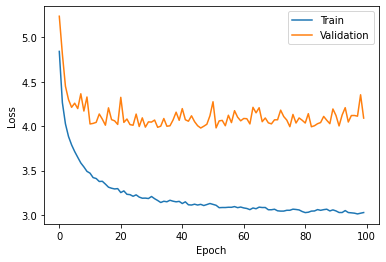

In [109]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [110]:
torch.save(model.get_config(), 'model_config.pt')

In [ ]:
# model_2 = MDenseNet.build_model('model_config.pt')
# model_2.load_state_dict(torch.load('trained_model_epoch_100.pt'))

In [111]:
def istft(input,
    n_fft=4096,
    hop_length=1024,
    win_length=4096,
    window=torch.hann_window(4096).cuda(),
    center=True,
    from_complex=True,
    num_channels=2):
    """
    input <torch.Tensor>: (num_samples x num_channels x fft_size x n_fft_frames)

    output <torch.Tensor>: (num_samples x num_channels x length)
    """
    
    if from_complex:
        num_samples, num_channels, fft_size, n_fft_frames = input.size()
        input = input.view(-1, fft_size, n_fft_frames)
    else:
        num_samples_, _, fft_size, n_fft_frames = input.size()
        num_samples = num_samples_ // num_channels
        input = input.movedim(1,-1).contiguous()
        input = torch.view_as_complex(input)

    istft = torch.istft(input, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center, return_complex=False)
    istft = istft.view(num_samples, num_channels, -1)

    return istft

In [112]:
sdrs = []
model.cuda()
preds, mixtures, targets = [], [], []
with torch.no_grad():
      for i, (mixture, target) in enumerate(valid_loader):
        print(i)
        pred_valid = istft(model(mixture), from_complex=False).cpu()
        mixture_valid = istft(mixture, from_complex=False).cpu()
        target_valid = istft(target, from_complex=False).cpu()
        preds.append(pred_valid)
        mixtures.append(mixture_valid)
        targets.append(target_valid)
        sdr = signal_distortion_ratio(
            pred_valid,
            target_valid).numpy().flatten()
        sdrs.append(sdr)

preds = torch.cat(preds).numpy()
mixtures = torch.cat(mixtures).numpy()
targets = torch.cat(targets).numpy()
final_sdr = np.concatenate(sdrs).mean()
print(f'final sdr: {final_sdr}')

0
1
final sdr: 3.395519937893174


In [121]:
import IPython.display as ipd
ipd.Audio(preds[0], rate=44100)

In [122]:
ipd.Audio(mixtures[0], rate=44100)

In [123]:
ipd.Audio(targets[0], rate=44100)

In [116]:
import scipy.io.wavfile

for i in tqdm.tqdm(range(len(preds))):
  scipy.io.wavfile.write(f'sample_output/preds/{i}.wav', 44100, preds[i].T)
  scipy.io.wavfile.write(f'sample_output/mixtures/{i}.wav', 44100, preds[i].T)
  scipy.io.wavfile.write(f'sample_output/targets/{i}.wav', 44100, targets[i].T)


100%|██████████| 14/14 [00:00<00:00, 63.66it/s]


In [ ]:
!zip -r sample_output.zip sample_output